### QML 4b. QSVM for Leukemia Data
Quantum vs Classical SVM for Leukemia data of 72 patients

This dataset comes from the classic Golub et al. (1999) paper, where microarray gene expression data was used to distinguish Acute Myeloid Leukemia (AML) from Acute Lymphoblastic Leukemia (ALL).

Samples (n ≈ 72): Each column corresponds to one patient’s leukemia sample. There are 47 ALL samples and 25 AML samples. Each row corresponds to a gene (a probe on the microarray). The cell values are gene expression levels (typically log-transformed intensities). The data set can be downloaded from [this link](http://hastie.su.domains/CASI_files/DATA/leukemia_small.csv)


If you are running this notebook in VS code, your environment must have the following libraries installed. If you are running this in google colab, you need to install the following libraries each time you initialize colab session.

`qiskit, qiskit-aer, qiskit-ibm-runtime, matplotlib, pylatexenc, pandas, scikit-learn`

### Step 1. Data import and preprocessing
Import the data and read a desired number of features, instead of all the features.

In [16]:
import pandas as pd
import numpy as np

# Load the CSV file
df_raw = pd.read_csv('leukemia_small.csv', header=None)

# Extract labels from the first row
labels = df_raw.iloc[0, :].values

# Extract data from rows 2 to 21 (index 1 to 20)
X = df_raw.iloc[1:11, :].astype(float).values
X = X.T
# Convert labels: ALL -> -1, AML -> 1
y = np.where(labels == 'ALL', -1, 1)
print('X.shape = ', X.shape, ', y.shape = ',y.shape)

X.shape =  (72, 10) , y.shape =  (72,)


In [17]:
# Rescale X to be within -pi to pi
X_min = np.min(X)
X_max = np.max(X)
X_rescaled = (X - X_min) / (X_max - X_min) * 2*(np.pi)
X = X_rescaled

### Step 2. Split data into test and training set

In [18]:
from sklearn.model_selection import train_test_split

# Split into 80% train, 20% test
X_train, X_test, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print('X_train.shape = ', X_train.shape, ', X_test.shape = ', X_test.shape)

X_train.shape =  (57, 10) , X_test.shape =  (15, 10)


### Step 3. Feature Map
Design an appropriate kernel circuit containing two parts. One part has trainable weights and the other part has feature encoding. We will use a custom feature map.

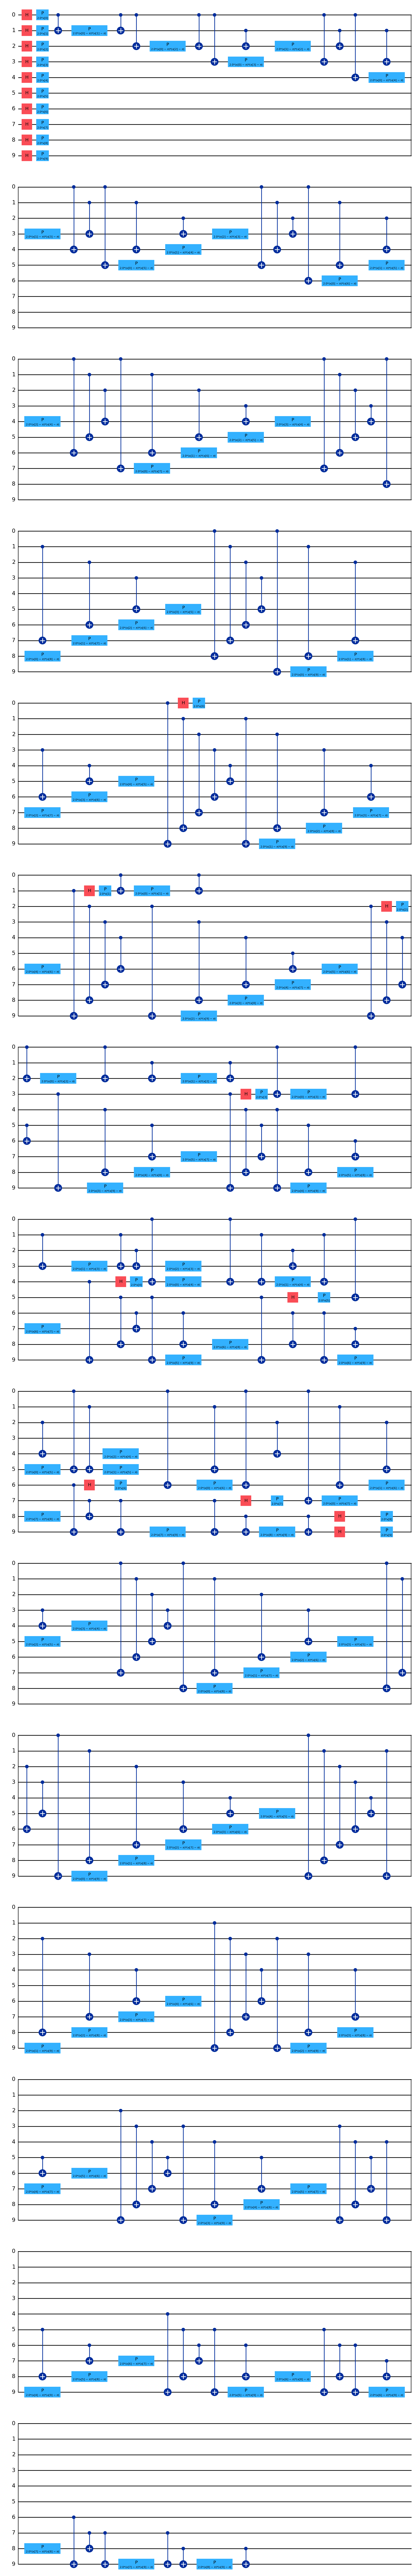

In [19]:
from qiskit.circuit.library import zz_feature_map
from qiskit.circuit.library import efficient_su2
num_features = np.shape(X_train)[1]
num_qubits = int(num_features)
# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
fm = zz_feature_map(num_qubits, reps=2,parameter_prefix="x")
fm.draw("mpl")

### Step 4. Kernel and Test matrices
We do not need to optimize for the simulator and we directly run the loop over the whole dataset to compute all kernel etnries 1. For training matrix, we compute inner product between each of the example with every other example, and just put 1 for the inner product with itself. 2. For test matrix, we compute the inner product of every example in the test set with every example in the training set.

In [20]:
# Empty kernel matrix
test_size = np.shape(X_test)[0]
train_size = np.shape(X_train)[0]
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan)
test_matrix = np.full((test_size, num_samples), np.nan)

In [21]:
# To use a simulator
from qiskit.primitives import StatevectorSampler
from qiskit.circuit.library import unitary_overlap
 
num_shots = 10000

sampler = StatevectorSampler()
 
for x1 in range(0, train_size):
    for x2 in range(x1 + 1, train_size):
        unitary1 = fm.assign_parameters(list(X_train[x1]))
        unitary2 = fm.assign_parameters(list(X_train[x2]))
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        # These lines run the qiskit sampler primitive.
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        # Assign the probability of the 0 state to the kernel matrix, and the transposed element (since this is an inner product)
        kernel_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
        kernel_matrix[x2, x1] = counts.get(0, 0.0) / num_shots
    # Fill in on-diagonal elements with 1, again, since this is an inner-product corresponding to probability (or alter the code to check these entries and verify they yield 1)
    kernel_matrix[x1, x1] = 1
 
print("training done")
 
# Similar process to above, but for testing data.
for x1 in range(0, test_size):
    for x2 in range(0, train_size):
        unitary1 = fm.assign_parameters(list(X_test[x1]))
        unitary2 = fm.assign_parameters(list(X_train[x2]))
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        test_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
 
print("test matrix done")

training done
test matrix done


Let us just visualize the kernel and test matrices

Text(0.5, 1.0, 'test matrix')

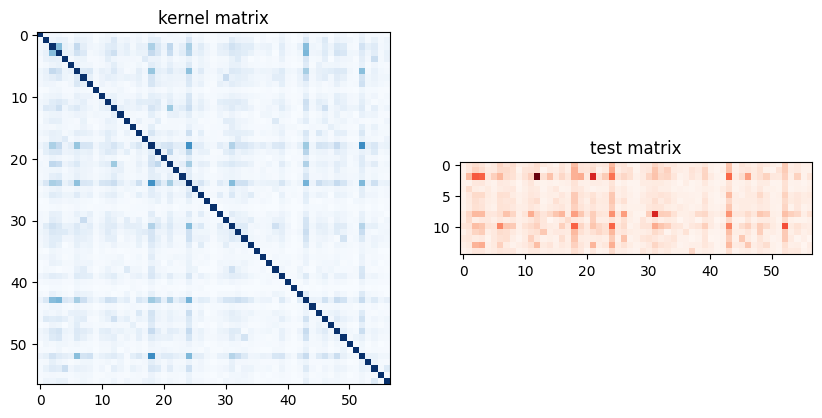

In [22]:
# Visualisation Imports
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(kernel_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("kernel matrix")

axs[1].imshow(np.asmatrix(test_matrix), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("test matrix")

### Step 3. Quantum SVM
We can now use the kernel matrix in the support vector machine class in sklearn and train it to build the statevector classifier SVC

In [23]:
# import a support vector classifier from a classical ML package.
from sklearn.svm import SVC
 
# Specify that you want to use a pre-computed kernel matrix
qml_svc = SVC(kernel="precomputed")

# Feed in the pre-computed matrix and the labels of the training data. The classical algorithm gives you a fit.
qml_svc.fit(kernel_matrix, train_labels)
 
# Now use the .score to test your data, using the matrix of test data, and test labels as your inputs.
qml_score_train_kernel = qml_svc.score(kernel_matrix, train_labels)
print(f"Quantum SVC classification training accuracy: {qml_score_train_kernel}")
qml_score_test_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Quantum SVC classification test accuracy: {qml_score_test_kernel}")

Quantum SVC classification training accuracy: 1.0
Quantum SVC classification test accuracy: 0.6666666666666666


### Step 6. Classical SVM for comparison
To compare with classical SVM, let use the same dataset for a classical SVM.

In [24]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(X_train, train_labels)  # suppress printing the return value
train_score_c = svc.score(X_train, train_labels)
test_score_c = svc.score(X_test, test_labels)


print(f"Classical SVC training accuracy: {train_score_c:.2f}")
print(f"Classical SVC test accuracy:     {test_score_c:.2f}")

Classical SVC training accuracy: 0.68
Classical SVC test accuracy:     0.67


The notebook is based on materials from various sources including  [IBM Quantum Learning](https://quantum.cloud.ibm.com/learning/en/courses/quantum-machine-learning). However, it has been significantly modified. The syntax is according to qiskit version 2.3.

Please cite/acknowledge my work when you use this notebook. Thanks. M. Faryad. [github/muf18](github.com/muf148)